# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev1 toc-item"><a href="#Last-time" data-toc-modified-id="Last-time-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Last time</a></div><div class="lev1 toc-item"><a href="#Evaluation" data-toc-modified-id="Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation</a></div><div class="lev2 toc-item"><a href="#Plotting-predicted-vs.-actual-values" data-toc-modified-id="Plotting-predicted-vs.-actual-values-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plotting predicted vs. actual values</a></div><div class="lev2 toc-item"><a href="#RMSE" data-toc-modified-id="RMSE-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RMSE</a></div><div class="lev2 toc-item"><a href="#$R^2$" data-toc-modified-id="$R^2$-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-27-Frame" tabindex="0" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msup&gt;&lt;mi&gt;R&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/msup&gt;&lt;/math&gt;" role="presentation" style="position: relative;"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-131" role="math" style="width: 1.29em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.063em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.252em, 1001.063em, 2.313em, -999.998em); top: -2.195em; left: 0.002em;"><span class="mrow" id="MathJax-Span-132"><span class="msubsup" id="MathJax-Span-133"><span style="display: inline-block; position: relative; width: 1.025em; height: 0px;"><span style="position: absolute; clip: rect(3.259em, 1000.608em, 4.131em, -999.998em); top: -4.013em; left: 0.002em;"><span class="mi" id="MathJax-Span-134" style="font-family: STIXMathJax_Main-italic;">R</span><span style="display: inline-block; width: 0px; height: 4.017em;"></span></span><span style="position: absolute; top: -4.392em; left: 0.608em;"><span class="mn" id="MathJax-Span-135" style="font-size: 70.7%; font-family: STIXMathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 4.017em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.199em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.043em; border-left-width: 0px; border-left-style: solid; width: 0px; height: 1.093em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msup><mi>R</mi><mn>2</mn></msup></math></span></span><script type="math/tex" id="MathJax-Element-27">R^2</script></a></div><div class="lev1 toc-item"><a href="#Overfitting" data-toc-modified-id="Overfitting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Overfitting</a></div>

# Setup

First we'll load some packages, including the recent `modelr` for easy modeling, setting options to warn us whenever observations with missing values are ignored by our models.

In [7]:
library(tidyverse)
library(scales)

library(modelr)
options(na.action = na.warn)

library(broom)

theme_set(theme_bw())
options(repr.plot.width=4, repr.plot.height=3)

Now we'll read in a file from last lecture with information on 225,000 anonymous Nielsen panelists, containing their age, gender, and the number of pages (~distinct urls) they typically access on their web browser each day, filtering out users with zero pageviews

In [8]:
users <- read_tsv(gzfile('users.tsv.gz'))

model_data <- filter(users, daily.views > 0, age >= 18 & age <= 65)

Parsed with column specification:
cols(
  age = col_integer(),
  gender = col_character(),
  daily.views = col_double()
)


# Last time

Now we'll fit the quadratic model from last time and remind ourselves of the design matrix and results.

In [9]:
form <- as.formula(log10(daily.views) ~ gender * (age + I(age^2)))
M <- model.matrix(form, model_data)
head(M)

(Intercept),genderMale,age,I(age^2),genderMale:age,genderMale:I(age^2)
1,0,55,3025,0,0
1,1,19,361,19,361
1,0,33,1089,0,0
1,1,38,1444,38,1444
1,0,65,4225,0,0
1,0,20,400,0,0


In [10]:
model <- lm(form, model_data)
tidy(model)
glance(model)

term,estimate,std.error,statistic,p.value
(Intercept),1.3111470352,2.022344e-02,64.83304,0.000000e+00
genderMale,0.5702781647,2.995316e-02,19.03900,9.614887e-81
age,0.0253548721,1.049913e-03,24.14950,1.174116e-128
I(age^2),-0.0003252173,1.274476e-05,-25.51772,2.169909e-143
genderMale:age,-0.0386189907,1.585310e-03,-24.36052,7.076032e-131
genderMale:I(age^2),0.0004569954,1.942110e-05,23.53086,2.932671e-122


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.01927013,0.01924476,0.6689456,759.6056,0,6,-196563.1,393140.2,393211.4,86497.68,193296


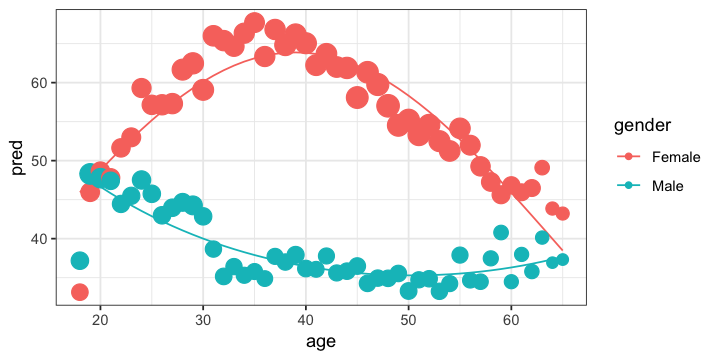

In [11]:
plot_data <- model_data %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)

options(repr.plot.width=6, repr.plot.height=3)
ggplot(plot_data, aes(x = age, y = pred, color = gender)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count)) +
  scale_size_area(guide = F)

# Evaluation

We decided that this looked reasonable last lecture in that the model was capturing the trends in the empirical averages by age and gender.

Let's first look at some more detailed plots to get a sense of how well the predicted and actual values match

## Plotting predicted vs. actual values

It's always a good idea to plot predicted vs. actual values along with a diagonal line to indicate how a perfect model would fit.

Often it's useful to bin points to show, for instance, the average actual outcome for all observations that were predicted to be in a small range.

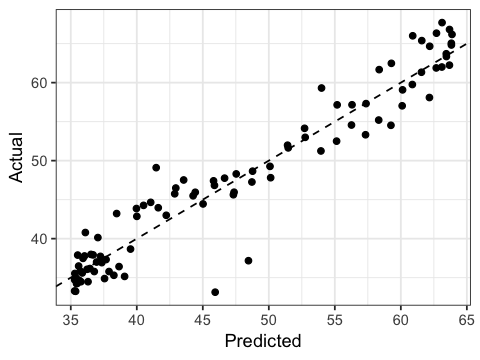

In [12]:
options(repr.plot.width=4, repr.plot.height=3)

ggplot(plot_data, aes(x = pred, y = geom_mean_daily_views)) +
  geom_point() +
  geom_abline(linetype = "dashed") +
  xlab('Predicted') +
  ylab('Actual')

We can use other aesthetics to add more information on these plots.
This can help identify where any systematic error might be creeping in.

For instance, we can color the points by gender.

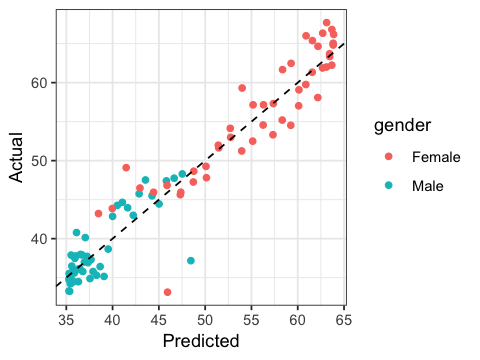

In [13]:
ggplot(plot_data, aes(x = pred, y = geom_mean_daily_views, color = gender)) +
  geom_point() +
  geom_abline(linetype = "dashed") +
  xlab('Predicted') +
  ylab('Actual')

And we can try to add age as well, although it's difficult to read the continuous color scale.

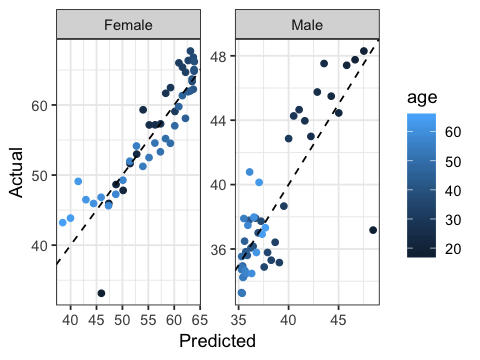

In [14]:
ggplot(plot_data, aes(x = pred, y = geom_mean_daily_views, color = age)) +
  geom_point() +
  geom_abline(linetype = "dashed") +
  xlab('Predicted') +
  ylab('Actual') +
  facet_wrap(~ gender, scale = "free")

Finally, we can do the same without binning.
This shows all individual predictions.

Trying to show 225,000 points is never a good idea, but in this case it demostrates how much variation there is at the individual level.

So even though we've done a reasonable job modeling the averages, there's still lots of unexplained variance.

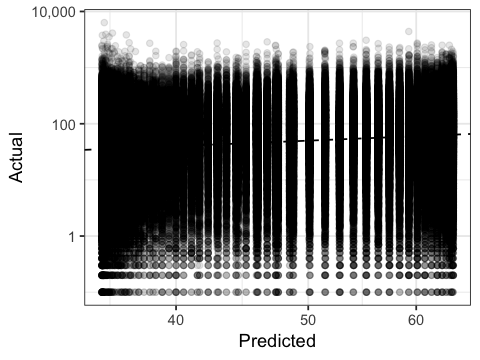

In [15]:
pred_actual <- model_data %>%
  add_predictions(model) %>%
  mutate(actual = log10(daily.views))

ggplot(pred_actual, aes(x = 10^pred, y = 10^actual)) +
  geom_point(alpha = 0.1) +
  geom_abline(linetype = "dashed") +
  scale_x_log10(label = comma, breaks = seq(0,100,by=10)) +
  scale_y_log10(label = comma) +
  xlab('Predicted') +
  ylab('Actual')

## RMSE

We can quantify the model fit in a number of ways.

One natural choice is to use the squared loss that was used in fitting the model, but to take a square root to adjust units to match those of the outcome (e.g., pageviews in this case).

In [16]:
pred_actual %>%
  summarize(rmse = sqrt(mean((pred - actual)^2)))

rmse
0.6689352


This is easy to compute, but a bit hard to interpret.
Especially because it represents an average error in log-pageview space.

We can always convert back to pageviews and measure the RMSE.

In [17]:
pred_actual %>%
  summarize(rmse = sqrt(mean((10^pred - 10^actual)^2)))

rmse
165.2601


Since we have a better sense of scale here, we can tell that an average error of 165 pageviews is a relatively poor fit!

## $R^2$

When we don't have a sense of scale, though, we can use the coefficient of determination, or $R^2$, to get a measure of performance.
$R^2$ measures the fraction of variance in outcomes explained by the model.

One way to compute this is to look at the Pearson correlation coefficient between predicted and actual values, and square it.

In [18]:
pred_actual %>%
  summarize(rmse = sqrt(mean((pred - actual)^2)),
            cor = cor(pred, actual),
            cor_sq = cor^2)

rmse,cor,cor_sq
0.6689352,0.1388169,0.01927013


There are functions in `modelr` for doing all of these more easily.

In [22]:
rmse(model, model_data)
rsquare(model, model_data)

[1] 0.6689352

[1] 0.01927013

This matches the reported $R^2$ in `summary(model)$r.squared` or `glance(model)`, and means that we're explaining just 2% of the variance in outcomes, verifying what we saw in the noisy scatter plot above.

This is equivalent as comparing the mean squared error (MSE) of the model to the MSE of a simple baseline where we always predict the average outcome.
We can compute the performance of this baseline explicitly and compare things to verify.

In [23]:
pred_actual %>%
  summarize(mse = mean((pred - actual)^2),
            mse_baseline = mean((mean(actual) - actual)^2),
            mse_vs_baseline = (mse_baseline - mse) / mse_baseline,
            cor = cor(pred, actual),
            cor_sq = cor^2)

mse,mse_baseline,mse_vs_baseline,cor,cor_sq
0.4474743,0.4562666,0.01927013,0.1388169,0.01927013


# Overfitting

Finally, we can make the point that a bigger model is not always a better one, for instance by fitting a ridiculously complex 30-degree polynomial to the browsing data.

In [24]:
K <- 30
form <- as.formula(log10(daily.views) ~ gender * poly(age, K, raw=T))
M <- model.matrix(form, model_data)
head(M)

(Intercept),genderMale,"poly(age, K, raw = T)1","poly(age, K, raw = T)2","poly(age, K, raw = T)3","poly(age, K, raw = T)4","poly(age, K, raw = T)5","poly(age, K, raw = T)6","poly(age, K, raw = T)7","poly(age, K, raw = T)8",⋯,"genderMale:poly(age, K, raw = T)21","genderMale:poly(age, K, raw = T)22","genderMale:poly(age, K, raw = T)23","genderMale:poly(age, K, raw = T)24","genderMale:poly(age, K, raw = T)25","genderMale:poly(age, K, raw = T)26","genderMale:poly(age, K, raw = T)27","genderMale:poly(age, K, raw = T)28","genderMale:poly(age, K, raw = T)29","genderMale:poly(age, K, raw = T)30"
1,0,55,3025,166375,9150625,503284375,27680640625,1.522435e+12,8.373394e+13,⋯,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,19,361,6859,130321,2476099,47045881,8.938717e+08,1.698356e+10,⋯,7.142095e+26,1.356998e+28,2.578296e+29,4.898763e+30,9.307650e+31,1.768453e+33,3.360061e+34,6.384117e+35,1.212982e+37,2.304666e+38
1,0,33,1089,35937,1185921,39135393,1291467969,4.261844e+10,1.406409e+12,⋯,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,38,1444,54872,2085136,79235168,3010936384,1.144156e+11,4.347792e+12,⋯,1.497806e+33,5.691662e+34,2.162832e+36,8.218760e+37,3.123129e+39,1.186789e+41,4.509798e+42,1.713723e+44,6.512149e+45,2.474616e+47
1,0,65,4225,274625,17850625,1160290625,75418890625,4.902228e+12,3.186448e+14,⋯,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0,20,400,8000,160000,3200000,64000000,1.280000e+09,2.560000e+10,⋯,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [28]:
model <- lm(form, model_data)
glance(model)
tidy(model)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.02063472,0.02043709,0.6685388,104.4085,0,40,-196428.5,392939,393356.1,86377.32,193262


term,estimate,std.error,statistic,p.value
(Intercept),-1.303723e+05,5.801182e+05,-0.2247340,0.8221865
genderMale,-1.678235e+05,2.093948e+05,-0.8014689,0.4228612
"poly(age, K, raw = T)1",5.969850e+04,2.748227e+05,0.2172255,0.8280329
"poly(age, K, raw = T)2",-1.268910e+04,5.980100e+04,-0.2121888,0.8319600
"poly(age, K, raw = T)3",1.653247e+03,7.903331e+03,0.2091836,0.8343051
"poly(age, K, raw = T)4",-1.465994e+02,7.059029e+02,-0.2076764,0.8354819
"poly(age, K, raw = T)5",9.268892e+00,4.476673e+01,0.2070487,0.8359721
"poly(age, K, raw = T)6",-4.242073e-01,2.053246e+00,-0.2066032,0.8363200
"poly(age, K, raw = T)7",1.388301e-02,6.753549e-02,0.2055661,0.8371301
"poly(age, K, raw = T)8",-3.075867e-04,1.514638e-03,-0.2030760,0.8390759


The model is so flexible that there's not even a numerically stable solution for a unique coefficient for each feature, as indicated by the `NA`s above.

Likewise, plotting the model shows a very complex function with patterns (e.g., oscillations in viewing activity for people in their 60s) that we don't believe.

Warning message in predict.lm(model, data):
“prediction from a rank-deficient fit may be misleading”

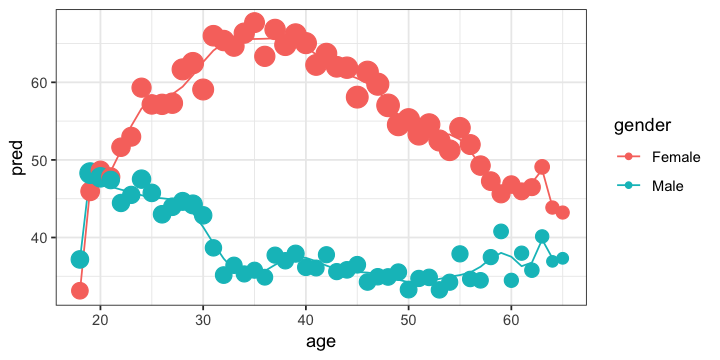

In [29]:
plot_data <- model_data %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)

options(repr.plot.width=6, repr.plot.height=3)
ggplot(plot_data, aes(x = age, y = pred, color = gender)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count)) +
  scale_size_area(guide = F)